In [1]:
import torch
import torchvision

In [2]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision import datasets,transforms 

In [3]:
transform=transforms.ToTensor()
train_data=datasets.MNIST(root='/data',train=True,download=True,transform=transform)
test_data=datasets.MNIST(root='/data',train=False,download=True,transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



In [4]:
def train_val_split(val_pct,seed):
  val_size=int(val_pct*len(train_data))
  train_size=len(train_data)-val_size
  torch.manual_seed(seed)
  train_ds, val_ds=random_split(train_data,[train_size,val_size])
  return [train_ds,val_ds]

In [5]:
train_ds,val_ds=train_val_split(1/6,42)
train_loader=DataLoader(train_ds,batch_size=100,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size=200,num_workers=4,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class NN_Base(nn.Module):
   def training_step(self,batch):
       images,labels=batch
       out=self(images)
       loss=F.cross_entropy(out,labels)
       return loss

   def validation_step(self,batch):
       images,labels=batch
       out=self(images)
       loss=F.cross_entropy(out,labels)

       acc=accuracy(out,labels)
       return {'val_loss':loss,'val_acc':acc}

   def end_validation(self,outputs):
       val_losses=[x['val_loss'] for x in outputs]
       val_loss_avg=torch.stack(val_losses).mean()
       val_accs=[x['val_acc'] for x in outputs]
       val_acc_avg=torch.stack(val_accs).mean()
       return {'val_loss_avg':val_loss_avg,'val_acc_avg':val_acc_avg}

   def epoch_end(self,epoch,outputs):
       print("Epoch: [{}]  Val_Loss: {:.4f}  Val_Acc: {:.4f}%  Train_Loss: {:,.4f}".format(epoch,outputs['val_loss_avg'],outputs['val_acc_avg']*100,outputs['train_loss']))
       
def accuracy(out,labels):
    _,preds=torch.max(out,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(labels))

In [8]:
class ANN_Model(NN_Base):
      def __init__(self):
         super().__init__()
         self.network=nn.Sequential(
            nn.Conv2d(1,2,kernel_size=3,stride=1,padding=3),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Conv2d(2,4,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(4,8,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(1024,256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256,32),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(32,10),
            nn.Sigmoid())
 
      def forward(self,x):
          return self.network(x)

In [9]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.end_validation(outputs)

In [10]:
model=ANN_Model()

In [11]:
def get_default_device():
    if torch.cuda.is_available():
      return torch.device('cuda')
    else:
      return torch.device('cpu')  
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
      def __init__(self,dl,device):
          self.dl=dl
          self.device=device

      def __iter__(self):
          for x in self.dl:
            yield to_device(x,self.device)

      def __len__(self):
        return len(self.dl)    

In [12]:
device=get_default_device()
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)
model=to_device(model,device)

In [13]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func):
    opt=opt_func(model.parameters(),lr,weight_decay=1e-4)
    scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.2,patience=1)
    history=[]
    for epoch in range(epochs):
      train_losses=[]
      model.train()
      for batch in train_loader:
        loss=model.training_step(batch)
        train_losses.append(loss)
        loss.backward()
        opt.step()
        opt.zero_grad()
      results=evaluate(model,val_loader)
      scheduler.step(results['val_loss_avg'])
      results['train_loss']=torch.sum(torch.tensor(train_losses)).item()/len(train_loader)
      model.epoch_end(epoch,results)
      history.append(results)
    return history

In [14]:
history=fit(11,1e-3,model,train_loader,val_loader,torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  Val_Loss: 1.4877  Val_Acc: 96.9600%  Train_Loss: 1.5810
Epoch: [1]  Val_Loss: 1.4821  Val_Acc: 97.4800%  Train_Loss: 1.4911
Epoch: [2]  Val_Loss: 1.4781  Val_Acc: 98.0500%  Train_Loss: 1.4835
Epoch: [3]  Val_Loss: 1.4752  Val_Acc: 98.2200%  Train_Loss: 1.4810
Epoch: [4]  Val_Loss: 1.4737  Val_Acc: 98.4400%  Train_Loss: 1.4788
Epoch: [5]  Val_Loss: 1.4765  Val_Acc: 98.1700%  Train_Loss: 1.4770
Epoch: [6]  Val_Loss: 1.4763  Val_Acc: 98.0900%  Train_Loss: 1.4759
Epoch: [7]  Val_Loss: 1.4715  Val_Acc: 98.7600%  Train_Loss: 1.4710
Epoch: [8]  Val_Loss: 1.4714  Val_Acc: 98.7800%  Train_Loss: 1.4702
Epoch: [9]  Val_Loss: 1.4712  Val_Acc: 98.7900%  Train_Loss: 1.4695
Epoch: [10]  Val_Loss: 1.4713  Val_Acc: 98.7400%  Train_Loss: 1.4692


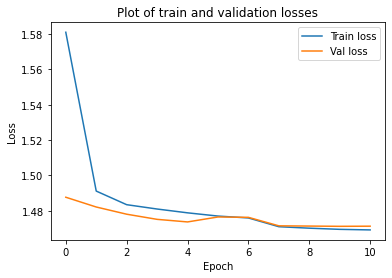

In [15]:
import matplotlib.pyplot as plt
plt.plot([x['train_loss'] for x in history])   
plt.plot([x['val_loss_avg'] for x in history])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Plot of train and validation losses')
plt.legend(['Train loss','Val loss'])

In [16]:
test_loader=DataLoader(dataset=test_data,batch_size=500)
test_loader=DeviceDataLoader(test_loader,device)
correct_count=0
for batch in test_loader:
  image,label=batch
  out=model(image)
  _,pred=torch.max(out,dim=1)
  correct_count+=torch.sum(pred==label).item()

acc=correct_count/len(test_data)
print("Final test accuracy:{}%".format(acc*100))

Final test accuracy:99.0%
